In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from pgmpy.models import NaiveBayes

## Data reading

In [2]:
df = pd.read_csv('dataset/adult.data', na_values=[' ?'])
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,high-income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


## Data pre-processing

### Strip leading and trailing spaces from column names and cell values

In [4]:
df.columns = df.columns.str.strip()
for column in df.columns.values:
    if df[column].dtype == 'object':
        df[column] = df[column].str.strip()
df.columns.values

array(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'high-income'], dtype=object)

### Removing redundant or useless features

In [5]:
useless_features = ['fnlwgt', 'education-num']
df.drop(columns=useless_features, inplace=True)
df.columns.values

array(['age', 'workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
       'hours-per-week', 'native-country', 'high-income'], dtype=object)

### Record variable names and the target variable (`high-income`)

In [6]:
variables_names = df.columns.values
target_variable = variables_names[-1]
feature_variables = variables_names[:-1]

### Checking for NA values

In [7]:
np.sum(pd.isnull(df), 0)

age                  0
workclass         1836
education            0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
high-income          0
dtype: int64

We can drop NA values, since they are only a few, w.r.t. the size of the dataset.

In [8]:
df = df.dropna()
np.sum(pd.isnull(df), 0)

age               0
workclass         0
education         0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
high-income       0
dtype: int64

### Binning continuos variables

In [9]:
def binning(column, bin_edges, categories=None):
    '''
    Bin the given pandas Series values into specific categories names associated 
    with numerical bins. If the categories list is not given, natural numbers 
    will be used as categories.
    '''
    if column.dtype == 'object':
        return column
    bins = [(bin_edges[i], bin_edges[i + 1]) for i in range(len(bin_edges) - 1)]
    if categories is None:
        categories = list(range(len(bins)))
    if len(categories) != len(bins):
        raise Exception(
            'The lenght of the bin edges list should be one element more than the lenght of the categories list.'
        )
    _categories = dict(zip(bins, categories))
    indices = np.digitize(column, bins=bin_edges)
    values = []
    for i in range(column.size):
        values.append(
            _categories[bins[indices[i] - 1]]
        )
    return pd.Series(values, index=column.index)

The `age` variable will be divided as follows:
* `age` < 18: `child`
* 18 <= `age` < 30: `young adult`
* 30 <= `age` < 60: `adult`
* `age` >= 60: `senior`

In [10]:
_age_bins_edges = [0, 18, 30, 60, 100]
_age_categories = ['child', 'young adult', 'adult', 'senior']
df['age'] = binning(column=df['age'].copy(), bin_edges=_age_bins_edges, categories=_age_categories)
df['age'].describe()

count     30162
unique        4
top       adult
freq      19296
Name: age, dtype: object

The `hours-per-week` variable will be divided as follows:
* `hours-per-week` < 25: `part time`
* 25 <= `hours-per-week` < 40: `full time`
* 40 <= `hours-per-week` < 60: `over time`
* `hours-per-week` >= 60: `too much time`

In [11]:
_hours_bins_edges = [0, 25, 40, 60, 100]
_hours_categories = ['part time', 'full time', 'over time', 'too much time']
df['hours-per-week'] = binning(column=df['hours-per-week'].copy(), bin_edges=_hours_bins_edges, categories=_hours_categories)
df['hours-per-week'].describe()

count         30162
unique            4
top       over time
freq          20991
Name: hours-per-week, dtype: object

## Train/test split

In [12]:
mask = np.random.rand(len(df)) < 0.8
train = df[mask]
test = df[~mask]
test.drop(target_variable, axis=1, inplace=True)
print(f"Training set shape: {train.shape}")
print(f"Test set shape: {test.shape}")

Training set shape: (24053, 13)
Test set shape: (6109, 12)


## Naive Bayes model

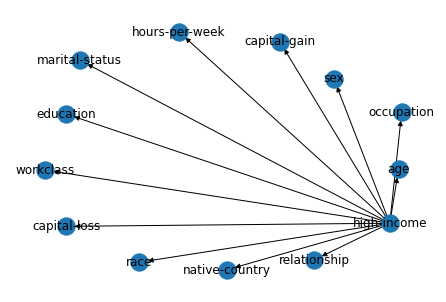

In [13]:
nb_model = NaiveBayes(
    feature_vars=feature_variables,
    dependent_var=target_variable
)
nx.draw(nb_model, with_labels=True)
plt.show()

### Estimate CPTs from data

In [14]:
nb_model.fit(train)
nb_model.get_cpds()

[<TabularCPD representing P(age:4 | high-income:2) at 0x14bf92a60>,
 <TabularCPD representing P(capital-gain:115 | high-income:2) at 0x14bf928e0>,
 <TabularCPD representing P(capital-loss:87 | high-income:2) at 0x14bf92f40>,
 <TabularCPD representing P(education:16 | high-income:2) at 0x14bf92bb0>,
 <TabularCPD representing P(high-income:2) at 0x14bfb73d0>,
 <TabularCPD representing P(hours-per-week:4 | high-income:2) at 0x14bfb7c10>,
 <TabularCPD representing P(marital-status:7 | high-income:2) at 0x14bfb7d00>,
 <TabularCPD representing P(native-country:41 | high-income:2) at 0x14bfb7fd0>,
 <TabularCPD representing P(occupation:14 | high-income:2) at 0x14bfb7ac0>,
 <TabularCPD representing P(race:5 | high-income:2) at 0x14bfb7ee0>,
 <TabularCPD representing P(relationship:6 | high-income:2) at 0x14bfb7d60>,
 <TabularCPD representing P(sex:2 | high-income:2) at 0x14bfb7ca0>,
 <TabularCPD representing P(workclass:7 | high-income:2) at 0x14bfca9d0>]

### Prediction on test data

In [19]:
nb_model.predict_probability(test)

KeyError: 2282